In [1]:
import pystac_client
import planetary_computer
import rioxarray as rio
import xarray as xr
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
from shapely import box
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from matplotlib.colors import LightSource
from matplotlib import animation
import cartopy.crs as ccrs
import xrspatial as xrs
plt.rcParams['font.family'] = 'DejaVu Sans Mono'

c:\Users\s1759665\Miniconda3\envs\xdem_plancomp\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.0. Please consider upgrading.
  warnings.warn(


In [2]:
sdnp_geom = shape({
      "coordinates": [[
            [-0.08985080593200223,50.858667861221164],
            [-0.08985080593200223,50.79414350067211],
            [0.007405918192461058,50.79414350067211],
            [0.007405918192461058,50.858667861221164],
            [-0.08985080593200223,50.858667861221164]]],
      "type": "Polygon"})

sdnp = gpd.GeoDataFrame(geometry=[sdnp_geom], crs=4326)
prj = ccrs.epsg(sdnp.estimate_utm_crs().to_epsg())

In [3]:
## get contours in aoi from copernicus global DEM hosted on planetary computer
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

search = catalog.search(collections=['cop-dem-glo-30'],
                        intersects=sdnp_geom.envelope)
items = list(search.get_items())

# if aoi crosses multiple DEM tiles stitch 'em together
if len(items) > 1:
    data = []
    for item in items:
        signed_asset = planetary_computer.sign(item.assets["data"])
        with rio.open_rasterio(signed_asset.href) as f:
            data.append(f.squeeze().drop_vars("band").rename('z'))
    dem = ((xr.merge(data))
           .rio.set_crs(4326)
           .rio.write_transform()
           .rio.clip_box(*sdnp_geom.bounds))['z']
    f.close()
else:
    signed_asset = planetary_computer.sign(items[0].assets["data"])
    dem =  (rio.open_rasterio(signed_asset.href)
            .squeeze()
            .rio.set_crs(4326)
            .rio.write_transform()
            .rio.clip_box(*sdnp_geom.bounds)).rename('z')

c:\Users\s1759665\Miniconda3\envs\xdem_plancomp\lib\site-packages\pystac_client\item_search.py:835: FutureWarning: get_items() is deprecated, use items() instead
  warnings.warn(


In [4]:
 # reproject to local utm crs
dem_prj = dem.rio.reproject(prj, resolution=30, nodata=np.nan)

# fix wonky
x,y=sdnp.to_crs(prj)['geometry'][0].exterior.coords.xy
sortx = np.sort(x)
sorty = np.sort(y)
minx, maxx=sortx[np.diff(sortx).argmax():np.diff(sortx).argmax()+2] ######## fiddly!
miny, maxy=sorty[np.diff(sorty).argmax():np.diff(sorty).argmax()+2]
dem_prj = dem_prj.rio.clip_box(minx,miny,maxx,maxy)

# dump out arrays
Z = dem_prj.values
X,Y = np.meshgrid(dem_prj.x.values, dem_prj.y.values)

In [5]:
randX = np.random.randint(low=np.floor(np.min(X)),
                          high=np.ceil(np.max(X)),
                          size=1200)

randY = np.random.randint(low=np.floor(np.min(Y)),
                          high=np.ceil(np.max(Y)),
                          size=1200)

coords = list(zip(randX,randY))

randZ = np.array([dem_prj.sel(x=x,
                              y=y,
                              method='nearest').values for
                  x,y in zip(randX,randY)])

MovieWriter Pillow unavailable; using Pillow instead.


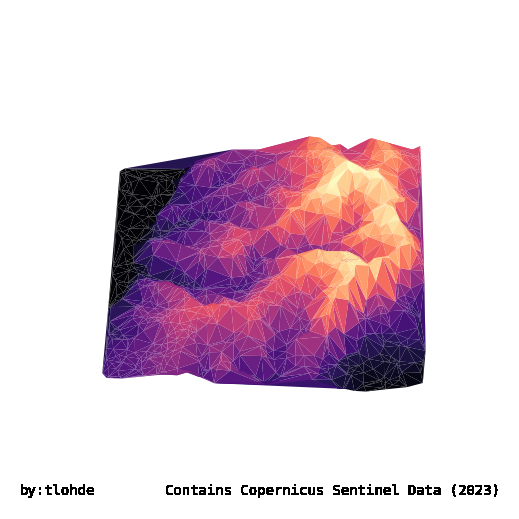

In [11]:
tri = mtri.Triangulation(randX,randY)
ls = LightSource(azdeg=-90, altdeg=35)
fig, ax = plt.subplots(subplot_kw={'projection':'3d'},figsize=[5,5])

ax.plot_trisurf(randX,randY,randZ, triangles=tri.triangles, alpha=0.99, cmap='magma', lightsource=ls)
ax.set_axis_off()
ax.set_box_aspect([1,1,0.2])
fig.subplots_adjust(left=0,bottom=0,right=1,top=1)

def animate(azi):
    elev = 15*(3+np.sin(np.deg2rad(azi)))
    ax.view_init(elev=elev,
                 azim=azi)
    ax.annotate(text='Contains Copernicus Sentinel Data (2023)',
            xy=(0.98,0.03), 
            xycoords='axes fraction', 
            ha='right', 
            fontsize=10)

    ax.annotate(text='by:tlohde',
                xy=(0.02,0.03), 
                xycoords='axes fraction',
                ha='left',
                fontsize=10)

    return fig

rot_animation = animation.FuncAnimation(fig,
                                        animate,
                                        frames=np.arange(1, 361, 2),
                                        interval=40)

rot_animation.save('rotation.gif',
                   dpi=100,
                   writer='Pillow')